## Import Libraries

In [1]:
import sys

sys.path.insert(1, '../')

import numpy as np
import pandas as pd
import scipy
import sklearn

from utils.arg_parser import *
from utils.import_data import *


from sne_example.method_sgn2 import *
from sne_example.method_gn import *
from sne_example.method_sgn import *
from sne_example.method_nspider import *
from sne_example.method_scgd import *


from matplotlib import pyplot as plt
import datetime, os, sys
import random

from sklearn.utils import resample

## Parse Arguments

In [2]:
# input arguments
sys.argv = ['sne_real_data.py', 
            '--obj', 'l2',      # objective type
            '-ne', '100',          # max num epochs
            '--seed', '42',        # seed
            '--alg', '1', '2','3', # algorithms to run 
            '--data', 'covtype',   # dataset name
            '--enable-log'         # save log data
           ]

# parse arguments
prog_option = argParser()

# extract options
is_plot         = prog_option["PlotOption"]
is_log          = prog_option["LogEnable"]
max_num_epochs  = prog_option["MaxNumEpoch"]
obj_type        = prog_option["Objective"]
seed_           = prog_option["Seed"]
dataset         = prog_option['Dataset']

alg_option = prog_option["Alg"]

## Input Preprocessing

In [3]:
# get data
X_data, Y_data = import_data(dataset)

# use sparse matrix for efficient computation
if not scipy.sparse.isspmatrix_csr(X_data):
    X_data = scipy.sparse.csr_matrix(X_data)

# get dimensions
n_ = X_data.shape[0]
d_ = X_data.shape[-1]

# prepare functions and data
Non_Linear_Func, Non_Linear_Data = intialize_func(4, X_data, Y_data)

if obj_type == 'l2':
    Objective_Func = {
        'Func': func_val_l2_norm,
        'Prox': prox_l2_norm,
        'DualFunc': ind_l2_ball,
        'DualProx': proj_l2_ball,
    }
elif obj_type == 'huber':
    Objective_Func = {
        'Func': func_val_huber,
        'Prox': prox_huber,
        'Grad': grad_eval_huber,
    }

## Parameter Initializations

In [4]:
if obj_type == 'l2':
    # sgn
    sgn_jac_batch_size = 512
    sgn_func_batch_size = 1024

    # sgn2
    sgn2_jac_batch_size = 128
    sgn2_func_batch_size = 256
    sgn2_jac_snap_batch_size = int(n_)
    sgn2_func_snap_batch_size = int(n_)
    sgn2_max_inner = 5000
    
elif obj_type == 'huber':
    # sgn
    sgn_jac_batch_size = 512
    sgn_func_batch_size = 1024

    # sgn2
    sgn2_jac_batch_size = 128
    sgn2_func_batch_size = 256
    sgn2_jac_snap_batch_size = int(n_)
    sgn2_func_snap_batch_size = int(n_)
    sgn2_max_inner = 5000

# Nested-SPIDER
nspider_jac_batch_size = 128
nspider_func_batch_size = 256
nspider_jac_snap_batch_size = int(n_)
nspider_func_snap_batch_size = int(n_)
nspider_max_inner = 5000
nspider_lr = 1.0

# SCGD
scgd_jac_batch_size = 512
scgd_func_batch_size = 1024
scgd_lr = 1.0

# general problem parameters
if obj_type == 'l2':
    sub_prob_params = {
        'rho': 5.0,
        'M_const': 5.0,
        'epsilon': 1e-6,
        'max_sub_iter': 100,
        'RelTolSoln': 1e-6, 
        'sub_solver': 'adpg',
        'n': n_,
        'd': d_,
    }
else:
    sub_prob_params = {
        'rho': 0.4,
        'M_const': 0.4,
        'epsilon': 1e-6,
        'max_sub_iter': 100,
        'RelTolSoln': 1e-6, 
        'sub_solver': 'adpg',
        'n': n_,
        'd': d_,
    }

# gn
gn_params = {
    'max_epochs':max_num_epochs,
}

# sgn
sgn_params = {
    'jac_batch': sgn_jac_batch_size,
    'func_batch': sgn_func_batch_size,
    'max_epochs':max_num_epochs,
}

# sgn2
sgn2_params = {
    'jac_batch': sgn2_jac_batch_size,
    'func_batch': sgn2_func_batch_size,
    'jac_snap_batch': sgn2_jac_snap_batch_size,
    'func_snap_batch': sgn2_func_snap_batch_size,
    'max_inner': sgn2_max_inner,
    'max_epochs':max_num_epochs,
}

# nested-spider
nspider_params = {
    'jac_batch': nspider_jac_batch_size,
    'func_batch': nspider_func_batch_size,
    'jac_snap_batch': nspider_jac_snap_batch_size,
    'func_snap_batch': nspider_func_snap_batch_size,
    'max_inner': nspider_max_inner,
    'max_epochs':max_num_epochs,
    'lr': nspider_lr,
    'epsilon': 1e-1,
}

# scgd
scgd_params = {
    'jac_batch': scgd_jac_batch_size,
    'func_batch': scgd_func_batch_size,
    'max_epochs': max_num_epochs,
    'lr': scgd_lr,
}

## Initial Point

In [5]:
# set seed
np.random.seed(seed_)

# generate initial point
x0 = np.ones(d_)

## Run Algorithms

In [6]:
# init history
history = []
legend_list = []
log_dir = []

# initialize log directory
example_name = 'SNE'
dataset = prog_option['Dataset']

### GN

In [7]:
# GN
hist = sne_gn(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, gn_params)
log_dir = os.path.join('log_file',example_name,dataset,obj_type,'GN', 
                "gn_rho_" + str(sub_prob_params['rho']) + "_M_" +str(sub_prob_params['M_const'])
                    + "_ne_{:d}".format(max_num_epochs))
if is_log:
    print('Saved to',log_dir)
    save_history(log_dir, hist)
history.append(hist)
legend_list.append('GN')


GN Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  9.54e-01   |    0.0     |   0.000e+00   |   6.211e-02   |   1.569e-02   |      inf     
  1.77e+00   |    2.0     |   1.162e+06   |   6.188e-02   |   1.559e-02   |   4.241e-04  
  2.87e+00   |    4.0     |   2.324e+06   |   6.165e-02   |   1.549e-02   |   4.214e-04  
  3.83e+00   |    6.0     |   3.486e+06   |   6.143e-02   |   1.539e-02   |   4.188e-04  
  4.84e+00   |    8.0     |   4.648e+06   |   6.121e-02   |   1.530e-02   |   4.162e-04  
  5.78e+00   |    10.0    |   5.810e+06   |   6.100e-02   |   1.521e-02   |   4.136e-04  
  6.90e+00   |    12.0    |   6.972e+06   |   6.078e-02   |   1.511e-02   |   4.111e-04  
  7.83e+00   |    14.0    |   8.134e+06   |   6.057e-02   |   1.502e-02   |   4.086e-04  
  8.76e+00   |    16.0    |   9.296e+06   |   6.036e-02   |   1.493e-02   |   4.061e

### SGN

In [8]:
# SGN
hist = sne_sgn(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, sgn_params)
log_dir = os.path.join('log_file',example_name,dataset,obj_type,'SGN', 
                "sgn_rho_" + str(sub_prob_params['rho']) + "_M_" +str(sub_prob_params['M_const'])
                + "_b1_" + str(sgn_params['jac_batch']) + "_b2_" + str(sgn_params['func_batch'])
                    + "_ne_{:d}".format(max_num_epochs))
if is_log:
    print('Saved to',log_dir)
    save_history(log_dir, hist)
history.append(hist)
legend_list.append('SGN')


SGN Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  8.48e-01   |    0.0     |   0.000e+00   |   6.211e-02   |   1.569e-02   |      inf     
  1.58e+01   |    2.0     |   1.163e+06   |   2.253e-02   |   3.348e-03   |   9.180e-05  
  3.10e+01   |    4.0     |   2.326e+06   |   1.546e-02   |   1.994e-03   |   5.276e-05  
  4.61e+01   |    6.0     |   3.488e+06   |   1.213e-02   |   1.431e-03   |   3.753e-05  
  6.05e+01   |    8.0     |   4.651e+06   |   1.013e-02   |   1.116e-03   |   2.989e-05  
  7.50e+01   |    10.0    |   5.814e+06   |   8.780e-03   |   9.154e-04   |   2.400e-05  
  9.02e+01   |    12.0    |   6.977e+06   |   7.795e-03   |   7.752e-04   |   1.805e-05  
  1.05e+02   |    14.0    |   8.139e+06   |   7.042e-03   |   6.720e-04   |   1.592e-05  
  1.20e+02   |    16.0    |   9.302e+06   |   6.445e-03   |   5.927e-04   |   1.503

### SGN2

In [9]:
# SGN2
hist = sne_sgn2(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, sgn2_params)
log_dir = os.path.join('log_file',example_name,dataset,obj_type,'SGN2', 
                "sgn2_rho_" + str(sub_prob_params['rho']) + "_M_" +str(sub_prob_params['M_const'])
                    + "_b1_" + str(sgn2_params['jac_batch']) + "_b2_" + str(sgn2_params['func_batch']) 
                    + "_inner_" + str(sgn2_params['max_inner'])+ "_ne_{:d}".format(max_num_epochs))
if is_log:
    print('Saved to',log_dir)
    save_history(log_dir, hist)
history.append(hist)
legend_list.append('SGN2')


SGN2 Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  7.49e-01   |    0.0     |   0.000e+00   |   6.211e-02   |   1.569e-02   |      inf     
  1.49e+00   |    4.0     |   2.324e+06   |   6.188e-02   |   1.559e-02   |   4.242e-04  
  1.55e+01   |    6.0     |   3.487e+06   |   1.531e-02   |   1.968e-03   |   5.206e-05  
  2.92e+01   |    8.0     |   4.650e+06   |   1.007e-02   |   1.107e-03   |   2.787e-05  
  4.36e+01   |    10.0    |   5.812e+06   |   7.763e-03   |   7.706e-04   |   1.906e-05  
  4.89e+01   |    14.6    |   8.488e+06   |   7.290e-03   |   7.055e-04   |   1.732e-05  
  6.27e+01   |    16.6    |   9.651e+06   |   6.125e-03   |   5.512e-04   |   1.338e-05  
  7.73e+01   |    18.6    |   1.081e+07   |   5.330e-03   |   4.516e-04   |   1.088e-05  
  9.16e+01   |    20.6    |   1.198e+07   |   4.750e-03   |   3.821e-04   |   9.13

### N-SPIDER

In [10]:
# N-SPIDER
if obj_type == 'huber':
    hist = sne_nspider(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, nspider_params)
    log_dir = os.path.join('log_file',example_name,dataset,obj_type,'N-SPIDER', 
                    "nspider_" + "lr_" + str(nspider_lr)
                        + "_b1_" + str(nspider_params['jac_batch']) + "_b2_" + str(nspider_params['func_batch']) 
                        + "_inner_" + str(nspider_params['max_inner'])+ "_ne_{:d}".format(max_num_epochs))
    if is_log:
        print('Saved to',log_dir)
        save_history(log_dir, hist)
    history.append(hist)
    legend_list.append('N-SPIDER')

### SCGD

In [11]:
# SCGD
if obj_type == 'huber':
    hist = sne_scgd(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, scgd_params)
    log_dir = os.path.join('log_file',example_name,dataset,obj_type,'SCGD', 
                    "scgd_" + "lr_" + str(nspider_lr)
                    + "_b1_" + str(sgn_params['jac_batch']) + "_b2_" + str(sgn_params['func_batch'])
                        + "_ne_{:d}".format(max_num_epochs))
    if is_log:
        print('Saved to',log_dir)
        save_history(log_dir, hist)
    history.append(hist)
    legend_list.append('SCGD')

## Plot Results

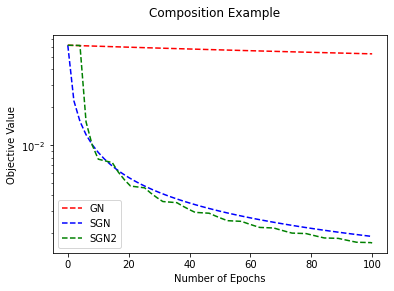

In [12]:
color = ['r','b','g']
color.extend(['C' + str(i) for i in range(10)])

fig1 = plt.figure()
# markfreq = 2
color_cnt = 0
for h in history:
    plt.semilogy(   np.array(h['Epochs']) ,
        np.array(h['Obj']) ,
        linestyle = '--',
        color = color[color_cnt],
                )
    color_cnt += 1

fig1.suptitle( 'Composition Example' )
plt.xlabel( "Number of Epochs" )
plt.ylabel( "Objective Value" )
plt.legend(legend_list)
plt.show()